In [98]:
import json
import requests
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pandas as pd
import matplotlib.pyplot as plt
import textacy
from random import sample
%matplotlib inline

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

# Analysis of Austen Novels Using Corpus-DB

First, get all the Jane Austen and George Eliot novels from Project Gutenberg.

In [2]:
# Create queries for corpus-DB
baseURL = "http://localhost:8000" # For local testing
#baseURL = "http://corpus-db.org" 

In [3]:
def getTextAndMeta(author): 
    metaResponse = requests.get(baseURL+"/api/author/"+author)
    textResponse = requests.get(baseURL+"/api/author/"+author+"/fulltext")
    meta = json.loads(metaResponse.text)
    texts = json.loads(textResponse.text)
    return meta, texts

In [4]:
austenMeta, austenTexts = getTextAndMeta("Austen, Jane")
eliotMeta, eliotTexts = getTextAndMeta("Eliot, George")

In [5]:
# Sanity check: how many novels did we get? 
len(austenMeta), len(austenTexts), len(eliotMeta), len(eliotTexts)

(20, 20, 19, 19)

In [6]:
# OK, that seems like a few too many. Let's pare it down a bit. 
# First, get the titles. 
[(book['id'], book['title']) for book in austenMeta]

[('105.0', 'Persuasion'),
 ('121.0', 'Northanger Abbey'),
 ('141.0', 'Mansfield Park'),
 ('158.0', 'Emma'),
 ('161.0', 'Sense and Sensibility'),
 ('946.0', 'Lady Susan'),
 ('1212.0', 'Love and Freindship [sic]'),
 ('1342.0', 'Pride and Prejudice'),
 ('21839.0', 'Sense and Sensibility'),
 ('25946.0', 'Gevoel en verstand'),
 ('31100.0',
  'The Complete Project Gutenberg Works of Jane Austen: A Linked Index of all PG Editions of Jane Austen'),
 ('33388.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 1)"),
 ('35151.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 2)"),
 ('35163.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 3)"),
 ('36777.0', 'Persuasion'),
 ('37431.0', "Pride and Prejudice, a play founded on Jane Austen's novel"),
 ('37634.0', "Raison et sensibilité, ou les deux manières d'aimer (Tome 4)"),
 ('42078.0',
  'The Letters of Jane Austen: Selected from the compilation of her great nephew, Edward, Lord Bradbourne'),
 ('42671.0', 'Pri

In [7]:
# Why don't we just get the ones that look like they're in English? 
# We can keep the juvenalia. 
myAustenCollection = [105, 121, 141, 158, 161, 946, 1212, 1342]

In [8]:
austenMetaSubset = [book for book in austenMeta if int(float(book['id'])) in myAustenCollection]
austenTextSubset = [book for book in austenTexts if int(book['id']) in myAustenCollection]

In [9]:
# Sanity check: how many do we have of each, now? 
len(austenMetaSubset), len(austenTextSubset)

(8, 8)

In [10]:
# Let's do the same for George Eliot. 
[(book['id'], book['title']) for book in eliotMeta]

[('145.0', 'Middlemarch'),
 ('507.0', 'Adam Bede'),
 ('550.0', 'Silas Marner'),
 ('2165.0', 'The Lifted Veil'),
 ('2171.0', 'Brother Jacob'),
 ('6688.0', 'The Mill on the Floss'),
 ('7469.0', 'Daniel Deronda'),
 ('10762.0', 'Impressions of Theophrastus Such'),
 ('17780.0', 'Scenes of Clerical Life'),
 ('20742.0', 'O May I Join the Choir Invisible! and Other Favorite Poems'),
 ('20813.0', 'How Lisa Loved the King'),
 ('24020.0', 'Romola'),
 ('24823.0', 'Silas Marner'),
 ('28289.0', 'The Essays of "George Eliot": Complete'),
 ('30273.0', 'Tom and Maggie Tulliver'),
 ('40882.0', 'Felix Holt, the Radical'),
 ('43043.0',
  "George Eliot's Life, as Related in Her Letters and Journals. Vol. 1 (of 3)"),
 ('43044.0',
  "George Eliot's Life, as Related in Her Letters and Journals. Vol. 2 (of 3)"),
 ('43045.0',
  "George Eliot's Life, as Related in Her Letters and Journals. Vol. 3 (of 3)")]

In [11]:
# Let's just grab the first 8, to make things even. 
myEliotCollection = [145, 507, 550, 2165, 2171, 6688, 7469, 10762]
eliotMetaSubset = [book for book in eliotMeta if int(float(book['id'])) in myEliotCollection]
eliotTextSubset = [book for book in eliotTexts if int(book['id']) in myEliotCollection]

In [12]:
# Sanity check: how many do we have? 
len(eliotMetaSubset), len(eliotTextSubset)

(8, 8)

# Comparative Stylometry of Austen and Eliot Novels

In [14]:
# Instantiate the models we need. 
tfidf = TfidfVectorizer(use_idf=False, max_features=800)
lsa = TruncatedSVD()

In [15]:
eliotTextsRaw = [t['text'] for t in eliotTextSubset]
austenTextsRaw = [t['text'] for t in austenTextSubset]

In [16]:
allTexts = eliotTextsRaw + austenTextsRaw
allTitles = [t['title'] for t in eliotMetaSubset] + [t['title'] for t in austenMetaSubset]

In [17]:
docTermMatrix = tfidf.fit_transform(allTexts)

In [18]:
lsaOut = lsa.fit_transform(docTermMatrix)

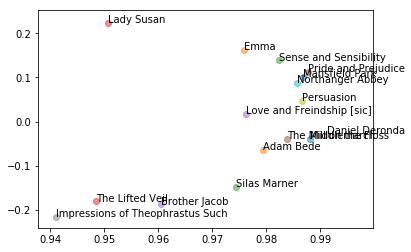

In [19]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], alpha=0.5)
    plt.annotate(allTitles[i], (xs[i], ys[i]))

In [20]:
# Is Love and Freindship really the most Eliot-like of Austen's novels? 

In [21]:
sum(['aaa', 'bbb', 'ccc'])

TypeError: unsupported operand type(s) for +: 'int' and 'str'

# Get Distinctive Words

In [97]:
def preprocess(text): 
    # Spacy doesn't know how to handle em-dashes, rendered
    # with hyphens, that don't have the correct amount of space around them. 
    text.replace('--', ' -- ')
    text
    return text

In [101]:
[len(t) for t in austenTextsRaw]

[466881, 433412, 883288, 883039, 673804, 127300, 184999, 684775]

In [92]:
def getBagOfWords(text): 
    """ Gets a bag of words representation of a text, 
    ignoring named entities, and lemmatizing along the way."""
    doc = textacy.Doc(text, lang='en')
    wordDict = {}
    for word in doc: 
        if word.ent_type == 0 \
        and word.tag_[:3] != 'NNP' \
        and not word.is_punct \
        and not word.is_space:
            if word.lemma_ in wordDict: 
                wordDict[word.lemma_] += 1
            else: 
                wordDict[word.lemma_] = 1
    return wordDict

In [96]:
austenBags = [getBagOfWords(preprocess(text)) for text in austenTextsRaw]

MemoryError: 

In [94]:
bag11

{'by': 419,
 'of': 2548,
 'in': 1384,
 'be': 4095,
 'a': 2528,
 'man': 163,
 'who': 190,
 'for': 703,
 '-PRON-': 9474,
 'own': 163,
 'amusement': 11,
 'never': 155,
 'take': 123,
 'up': 90,
 'any': 199,
 'book': 18,
 'but': 663,
 'the': 3156,
 'baronetage': 1,
 'there': 284,
 'find': 124,
 'occupation': 5,
 'and': 2776,
 'consolation': 4,
 'distress': 26,
 'one': 113,
 'faculty': 1,
 'rouse': 11,
 'into': 98,
 'admiration': 10,
 'respect': 26,
 'contemplate': 5,
 'limit': 4,
 'remnant': 1,
 'early': 34,
 'patent': 1,
 'unwelcome': 3,
 'sensation': 14,
 'arise': 7,
 'from': 293,
 'domestic': 11,
 'affair': 8,
 'change': 47,
 'naturally': 6,
 'pity': 13,
 'contempt': 5,
 'turn': 54,
 'over': 84,
 'almost': 57,
 'endless': 1,
 'creation': 3,
 'if': 201,
 'every': 95,
 'other': 197,
 'leaf': 1,
 'powerless': 1,
 'can': 593,
 'read': 21,
 'history': 17,
 'with': 648,
 'interest': 61,
 'which': 416,
 'fail': 14,
 'this': 273,
 'page': 3,
 'at': 530,
 'favourite': 9,
 'volume': 6,
 'always': 

In [49]:
allAusten = ' '.join(austenTextsRaw)
allEliot = ' '.join(eliotTextsRaw)

In [68]:
tfidf = TfidfVectorizer(stop_words='english')

In [69]:
twoDocTermMatrix = tfidf.fit_transform([allAusten, allEliot])

In [70]:
wordList = tfidf.get_feature_names()

In [71]:
twoDocTermMatrix

<2x31100 sparse matrix of type '<class 'numpy.float64'>'
	with 42315 stored elements in Compressed Sparse Row format>

In [72]:
df = pd.DataFrame(twoDocTermMatrix.todense(), columns=wordList, index=["Austen", "Eliot"])

In [73]:
df

,000,10,10th,11,11th,12,12th,13,1399,13th,...,zone,zones,zoological,zoology,zounds,zu,zum,zunz,zuzitotzums,zuzumotzis
Austen,0.000412,0.000977,0.000275,0.000391,0.000137,0.000489,0.000137,0.000391,0.000137,0.000293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Eliot,0.000000,0.000119,0.000000,0.000119,0.000000,0.000119,0.000000,0.000119,0.000000,0.000060,...,0.000168,0.000084,0.000168,0.000084,0.000084,0.00042,0.000168,0.000168,0.000084,0.000839


In [77]:
# Words distinctive of Austen (v. Eliot)
(df.loc['Austen']-df.loc['Eliot']).sort_values(ascending=False).head(20)

miss         0.152625
emma         0.119074
mrs          0.112124
fanny        0.094988
crawford     0.083091
soon         0.079798
marianne     0.079520
lady         0.075585
elizabeth    0.072578
elinor       0.066400
sister       0.064858
weston       0.060430
catherine    0.059071
did          0.057592
darcy        0.057271
jane         0.057117
mr           0.055743
dear         0.055172
knightley    0.053426
elton        0.053014
dtype: float64

In [78]:
# Words distinctive of Eliot (v. Austen)
(df.loc['Eliot']-df.loc['Austen']).sort_values(ascending=False).head(20)

said          0.260933
maggie        0.117673
like          0.107924
deronda       0.106930
adam          0.102985
gwendolen     0.099040
lydgate       0.084184
ll            0.070316
don           0.067075
tom           0.064980
grandcourt    0.063957
come          0.061876
tulliver      0.060264
ve            0.056993
dorothea      0.055837
casaubon      0.054892
life          0.054258
old           0.048807
bulstrode     0.048093
things        0.047862
dtype: float64

# Topic Modeling with Non-Negative Matrix Factorization

In [37]:
tfidf2 = TfidfVectorizer(max_df=0.95, min_df=3, max_features=1000, stop_words='english', use_idf=True)
docTermMatrix2 = tfidf2.fit_transform(allTexts)
featureNames = tfidf2.get_feature_names()

In [41]:
nmf = NMF(n_components=12, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(docTermMatrix2)

In [42]:
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(nmf, featureNames, 10)

Topic 0:
willoughby mrs lucy edward sister colonel middleton john miss fanny
Topic 1:
mrs new don going miss yes dear turned vision mary
Topic 2:
tom philip lucy bob ve ll mrs em don bessy
Topic 3:
david jacob freely shop box edward ll faces expression extraordinary
Topic 4:
anne captain russell walter mrs louisa charles mary elizabeth admiral
Topic 5:
susan james mrs dear daughter letter sister martin london miss
Topic 6:
emma harriet miss mrs jane frank dear body martin friend
Topic 7:
fanny thomas miss julia mrs grant maria henry william sister
Topic 8:
catherine miss henry mrs friend bath abbey james dear yes
Topic 9:
edward dear letter miss charlotte replied henry amiable louisa oh
Topic 10:
adam arthur thee ll th ve wi ud em ha
Topic 11:
elizabeth lydia jane mrs miss sister catherine charlotte friend colonel


In [40]:
nmf.components_.shape

(8, 1000)

# Topic Modeling with Latent Dirirchlet Allocation

In [43]:
tf = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
docCountsMatrix = tf.fit_transform(allTexts)
ldaFeatureNames = tf.get_feature_names()

In [44]:
lda = LatentDirichletAllocation(n_topics=10, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(docCountsMatrix)

In [45]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, ldaFeatureNames, no_top_words)

Topic 0:
mrs miss deronda emma fanny going new oh dear round
Topic 1:
mrs dear dorothea miss yes don going adam mary ll
Topic 2:
adam hetty ll mrs thee arthur ve going don th
Topic 3:
mrs miss emma elinor dear catherine marianne sister harriet friend
Topic 4:
fanny miss mrs edmund thomas bertram sister dear aunt william
Topic 5:
deronda elizabeth mrs miss sister lydia jane dear hugo new
Topic 6:
mrs dorothea ll don tom new ve miss going dear
Topic 7:
mrs tom don dorothea new going deronda ll oh ve
Topic 8:
new ll adam mrs don going deronda dear miss ve
Topic 9:
fanny mrs ll miss ve adam silas new yes edmund
